In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import sklearn
from sklearn.metrics import classification_report
from keras.applications import *
from keras.layers import *
from keras.models import Model, load_model
from keras.optimizers import Adam
from sklearn.utils import class_weight
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.efficientnet_v2 import preprocess_input as base_preprocess
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, RocCurveDisplay, auc
from sklearn.utils.multiclass import unique_labels
from collections import Counter
from pathlib import Path
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import itertools

Load data

In [ ]:
data = np.load('/content/drive/MyDrive/SC Lab/Dataset/data.npy',mmap_mode='r')
labels = np.load('/content/drive/MyDrive/SC Lab/Dataset/labels.npy',mmap_mode='r')

In [ ]:
print("Data shape:", data.shape)
print("Labels shape:", labels.shape)

Data shape: (10015, 224, 224, 3)
Labels shape: (10015, 7)


Loading Images from the data

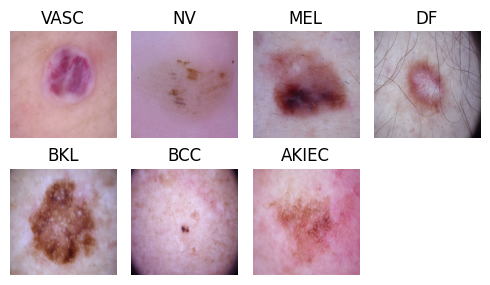

In [ ]:
# Get unique class labels and their corresponding indices in the data array
unique_classes = np.unique(labels, axis=1)

# Create a dictionary to store one data sample from each class
class_samples = {}

# Map class indices to their corresponding names
class_names = {0: "AKIEC", 1: "BCC", 2: "BKL", 3: "DF", 4: "MEL", 5: "NV", 6: "VASC"}

# Select one data sample from each class
for class_label in unique_classes:
    class_indices = np.where(np.all(labels == class_label, axis=1))[0]
    class_samples[tuple(class_label)] = data[class_indices[0]]

# Plot the images in 2 rows
plt.figure(figsize=(5, 3))
for i, (class_label, image_data) in enumerate(class_samples.items()):
    class_index = np.argmax(class_label)  # Get the index of the class
    class_name = class_names[class_index]  # Get the corresponding class name
    plt.subplot(2, 4, i + 1)
    plt.imshow(image_data)
    plt.title(f'{class_name}')
    plt.axis('off')

plt.tight_layout()
plt.show()

Frequency of the data

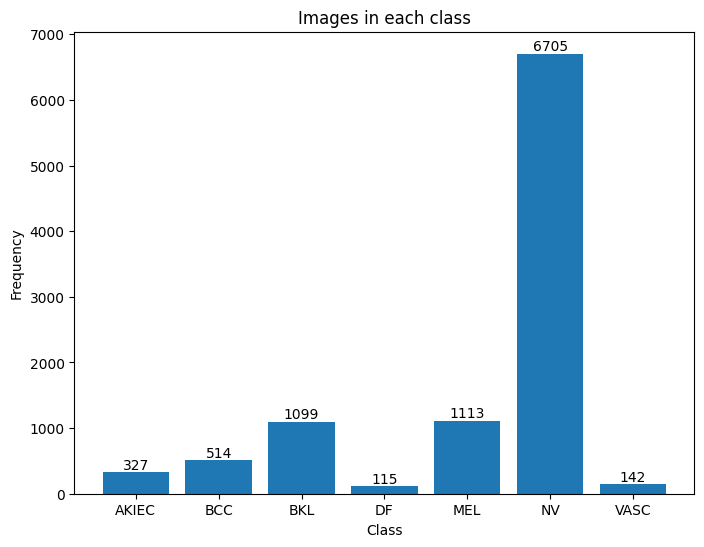

In [ ]:
# Sum the one-hot encoded labels along the rows to get the frequency of each class
class_counts = np.sum(labels, axis=0)

# Map class indices to their corresponding names
class_names = {0: "AKIEC", 1: "BCC", 2: "BKL", 3: "DF", 4: "MEL", 5: "NV", 6: "VASC"}

# Plot the class frequencies
plt.figure(figsize=(8, 6))
plt.bar([class_names[class_idx] for class_idx in range(len(class_names))], class_counts)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Images in each class')

# Annotate the bars with the class frequencies (integer format)
for i, count in enumerate(class_counts):
    plt.text(i, count, str(int(count)), ha='center', va='bottom')

plt.show()

Split data

In [ ]:
# Split the data into train, test, and validation sets
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.1,stratify=labels, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.1,stratify=train_labels, random_state=42)

Augmentation

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

Model

In [ ]:
lr_reduce = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.5, patience = 5,mode='max', min_lr = 1e-4,verbose = 1)
saved_model = '/content/drive/MyDrive/SC Lab/Saved Model/EfficientNetV2M.h5'
model_chkpt = ModelCheckpoint(saved_model ,save_best_only = True, monitor = 'val_accuracy',verbose = 1)
callback_list = [model_chkpt, lr_reduce]

In [ ]:
base_model = EfficientNetV2M(weights='imagenet',
                        include_top=False,
                        input_shape=(224, 224, 3))

214201816/214201816 [==============================] - 7s 0us/step


In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
epochs = 50
batch_size = 16

In [ ]:
history = model.fit(datagen.flow(train_data, train_labels, batch_size=batch_size),
                    validation_data=(val_data, val_labels),
                    epochs=epochs,
                    callbacks=callback_list)

Epoch 1/50
507/507 [==============================] - ETA: 0s - loss: 1.0207 - accuracy: 0.6561
Epoch 1: val_accuracy improved from -inf to 0.70288, saving model to /content/drive/MyDrive/4.2/SC Lab/Project/Saved Model/EfficientNetV2M.h5
507/507 [==============================] - 304s 515ms/step - loss: 1.0207 - accuracy: 0.6561 - val_loss: 0.8485 - val_accuracy: 0.7029 - lr: 0.0010
Epoch 2/50
507/507 [==============================] - ETA: 0s - loss: 0.9174 - accuracy: 0.6809
Epoch 2: val_accuracy did not improve from 0.70288
507/507 [==============================] - 247s 486ms/step - loss: 0.9174 - accuracy: 0.6809 - val_loss: 1.0370 - val_accuracy: 0.6918 - lr: 0.0010
Epoch 3/50
507/507 [==============================] - ETA: 0s - loss: 0.8436 - accuracy: 0.6917
Epoch 3: val_accuracy improved from 0.70288 to 0.72506, saving model to /content/drive/MyDrive/4.2/SC Lab/Project/Saved Model/EfficientNetV2M.h5
507/507 [==============================] - 267s 525ms/step - loss: 0.8436 - ac

In [ ]:
model= load_model('/content/drive/MyDrive/4.2/SC Lab/Project/Saved Model/EfficientNetV2M.h5')

In [ ]:
history = model.fit(datagen.flow(train_data, train_labels, batch_size=batch_size),
                    validation_data=(val_data, val_labels),
                    epochs=10,
                    callbacks=callback_list)

Epoch 1/10
507/507 [==============================] - ETA: 0s - loss: 0.1978 - accuracy: 0.9278
Epoch 1: val_accuracy improved from -inf to 0.85144, saving model to /content/drive/MyDrive/4.2/SC Lab/Project/Saved Model/EfficientNetV2M.h5
507/507 [==============================] - 322s 573ms/step - loss: 0.1978 - accuracy: 0.9278 - val_loss: 0.4915 - val_accuracy: 0.8514 - lr: 2.5000e-04
Epoch 2/10
507/507 [==============================] - ETA: 0s - loss: 0.1893 - accuracy: 0.9343
Epoch 2: val_accuracy did not improve from 0.85144
507/507 [==============================] - 248s 488ms/step - loss: 0.1893 - accuracy: 0.9343 - val_loss: 0.5404 - val_accuracy: 0.8404 - lr: 2.5000e-04
Epoch 3/10
507/507 [==============================] - ETA: 0s - loss: 0.1936 - accuracy: 0.9290
Epoch 3: val_accuracy did not improve from 0.85144
507/507 [==============================] - 247s 487ms/step - loss: 0.1936 - accuracy: 0.9290 - val_loss: 0.4909 - val_accuracy: 0.8503 - lr: 2.5000e-04
Epoch 4/10
5

In [ ]:
model= load_model('/content/drive/MyDrive/4.2/SC Lab/Project/Saved Model/EfficientNetV2M.h5')

In [ ]:
history = model.fit(datagen.flow(train_data, train_labels, batch_size=batch_size),
                    validation_data=(val_data, val_labels),
                    epochs=20,
                    callbacks=callback_list)

Epoch 1/20
507/507 [==============================] - ETA: 0s - loss: 0.1267 - accuracy: 0.9538
Epoch 1: val_accuracy improved from -inf to 0.83259, saving model to /content/drive/MyDrive/4.2/SC Lab/Project/Saved Model/EfficientNetV2M1.h5
507/507 [==============================] - 288s 504ms/step - loss: 0.1267 - accuracy: 0.9538 - val_loss: 0.7024 - val_accuracy: 0.8326 - lr: 1.2500e-04
Epoch 2/20
507/507 [==============================] - ETA: 0s - loss: 0.1220 - accuracy: 0.9567
Epoch 2: val_accuracy improved from 0.83259 to 0.85698, saving model to /content/drive/MyDrive/4.2/SC Lab/Project/Saved Model/EfficientNetV2M1.h5
507/507 [==============================] - 266s 525ms/step - loss: 0.1220 - accuracy: 0.9567 - val_loss: 0.6050 - val_accuracy: 0.8570 - lr: 1.2500e-04
Epoch 3/20
507/507 [==============================] - ETA: 0s - loss: 0.1262 - accuracy: 0.9567
Epoch 3: val_accuracy did not improve from 0.85698
507/507 [==============================] - 241s 475ms/step - loss: 0

In [ ]:
model= load_model('/content/drive/MyDrive/SC Lab/Saved Model/EfficientNetV2M.h5')

Test Accuracy

In [ ]:
test_loss, test_accuracy = model.evaluate(test_data, test_labels)
print("Test Accuracy:", test_accuracy)

32/32 [==============================] - 13s 230ms/step - loss: 0.6494 - accuracy: 0.8503
Test Accuracy: 0.8502994179725647


Classification Report

In [ ]:
# Make predictions on the test data
predictions = model.predict(test_data)

# Convert predictions and true labels to integer format
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)

# Calculate the classification report
report = classification_report(true_labels, predicted_labels)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Print the classification report
print("Classification Report:")
print(report)


32/32 [==============================] - 21s 206ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.42      0.58        33
           1       0.76      0.76      0.76        51
           2       0.67      0.73      0.70       110
           3       0.56      0.42      0.48        12
           4       0.70      0.56      0.62       111
           5       0.91      0.95      0.93       671
           6       0.93      0.93      0.93        14

    accuracy                           0.85      1002
   macro avg       0.78      0.68      0.71      1002
weighted avg       0.85      0.85      0.84      1002



Confusion Matrix

In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(true_labels, np.round(predicted_labels))

cm

array([[ 14,   5,  13,   0,   0,   1,   0],
       [  0,  39,   6,   1,   1,   4,   0],
       [  0,   2,  80,   2,   7,  19,   0],
       [  0,   0,   0,   5,   2,   5,   0],
       [  1,   2,  10,   0,  62,  36,   0],
       [  0,   3,  11,   1,  16, 639,   1],
       [  0,   0,   0,   0,   0,   1,  13]])

Normalized confusion matrix


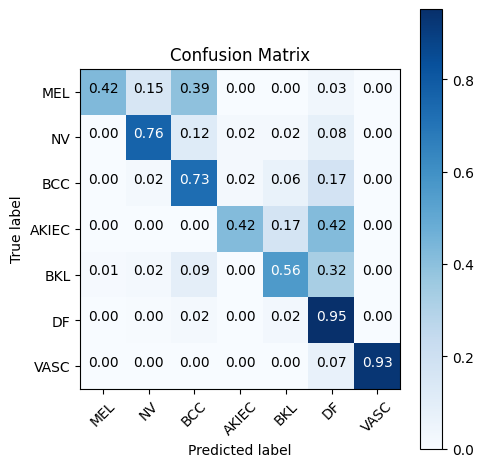

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


cm_plot_labels = ["MEL", "NV", "BCC", "AKIEC", "BKL", "DF", "VASC"]

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix', normalize=True)

ROC-AUC curve

32/32 [==============================] - 6s 179ms/step


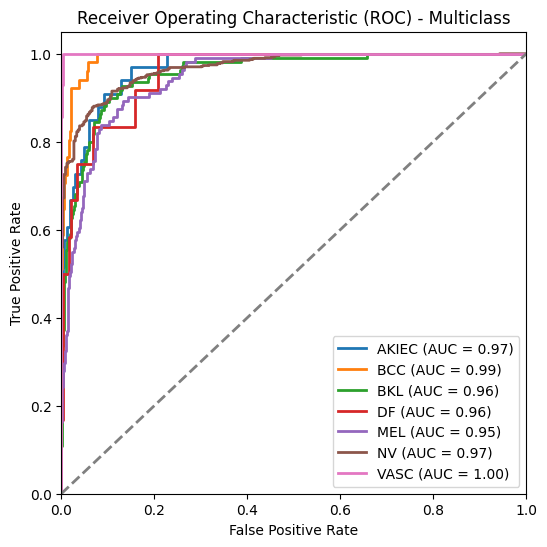

In [ ]:
# Define class names
class_names = ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']

# Make predictions on the test data
predictions = model.predict(test_data)

# Get the number of classes
num_classes = test_labels.shape[1]

# Initialize a figure to plot ROC curves
plt.figure(figsize=(6, 6))

# Loop through each class
for class_index in range(num_classes):
    # Compute ROC curve and ROC AUC for the current class
    fpr, tpr, thresholds = roc_curve(test_labels[:, class_index], predictions[:, class_index])
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve for the current class
    plt.plot(fpr, tpr, lw=2, label=f'{class_names[class_index]} (AUC = {roc_auc:.2f})')

# Plot the diagonal line (random chance)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)

# Set plot properties
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Multiclass')
plt.legend(loc='lower right')

# Display the plot
plt.show()

Misclass Classification

In [ ]:
!pip install tf-keras-vis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 1.9 MB/s eta 0:00:00


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from tensorflow.python.client import device_lib
device_list = device_lib.list_local_devices()
gpus = [device.name for device in device_list if device.device_type == 'GPU']
print('TensorFlow recognized {} GPUs'.format(len(gpus)))

TensorFlow recognized 1 GPUs


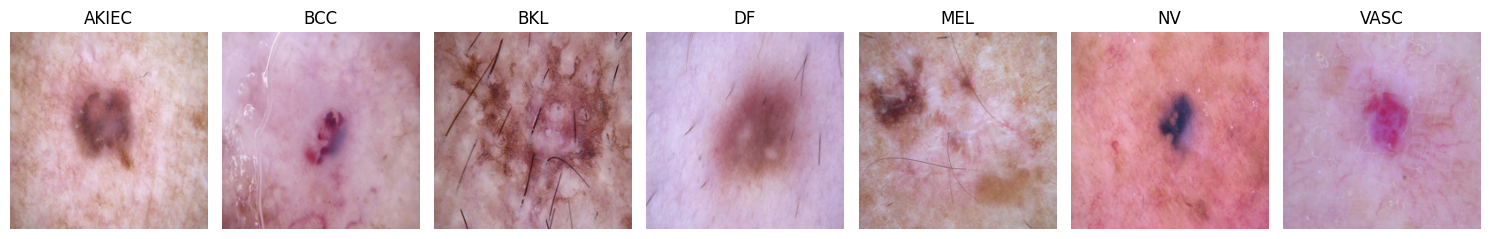

In [ ]:
image_titles = ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']
num_images = len(image_titles)

# Convert one-hot encoded labels to integer labels
# test_labels_int = np.argmax(test_labels, axis=1)
# # Find the indices of the first image from each class
# class_indices = [np.where(test_labels_int == i)[0][0] for i in range(len(image_titles))]

# # Create an array to store the images
# image_array = []

# # Create subplots with 2 rows
# num_rows = 2
# num_cols = (num_images + 1) // num_rows
# fig, ax = plt.subplots(num_rows, num_cols, figsize=(5, 3))

# for i, title in enumerate(image_titles):
#     row = i // num_cols
#     col = i % num_cols
#     ax[row, col].set_title(title, fontsize=8)

#     # Display the image from test data
#     img = test_data[class_indices[i]]
#     image_array.append(img)  # Store the image in the array

#     ax[row, col].imshow(img)
#     ax[row, col].axis('off')

# # Remove any empty subplots
# for i in range(len(image_titles), num_rows * num_cols):
#     row = i // num_cols
#     col = i % num_cols
#     fig.delaxes(ax[row, col])

# plt.tight_layout()
# plt.show()

# X = base_preprocess(np.array(image_array))

test_labels_int = np.argmax(test_labels, axis=1)
# Find the indices of the first image from each class
class_indices = [np.where(test_labels_int == i)[0][0] for i in range(len(image_titles))]

# Create an array to store the images
image_array = []

# Create a single row of plots
num_images = len(image_titles)
fig, ax = plt.subplots(1, num_images, figsize=(15, 3))

for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=12)
    ax[i].axis('off')

    # Display the image from test data
    img = test_data[class_indices[i]]
    image_array.append(img)  # Store the image in the array

    ax[i].imshow(img)

plt.tight_layout()
plt.show()

X = base_preprocess(np.array(image_array))

Random Image

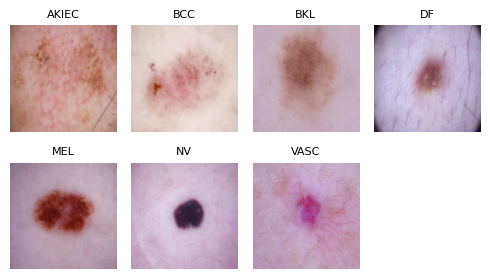

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

image_titles = ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']
num_images = len(image_titles)

# Convert one-hot encoded labels to integer labels
test_labels_int = np.argmax(test_labels, axis=1)
# Create an array to store the images
image_array = []

# Create subplots with 2 rows
num_rows = 2
num_cols = (num_images + 1) // num_rows
fig, ax = plt.subplots(num_rows, num_cols, figsize=(5, 3))

for i, title in enumerate(image_titles):
    row = i // num_cols
    col = i % num_cols
    ax[row, col].set_title(title, fontsize=8)

    # Find indices of images for the current class
    class_indices = np.where(test_labels_int == i)[0]
    random_index = np.random.choice(class_indices)  # Choose a random index

    # Display the image from test data
    img = test_data[random_index]
    image_array.append(img)  # Store the image in the array

    ax[row, col].imshow(img)
    ax[row, col].axis('off')

# Remove any empty subplots
for i in range(len(image_titles), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    fig.delaxes(ax[row, col])

plt.tight_layout()
plt.show()

X = base_preprocess(np.array(image_array))


In [ ]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

replace2linear = ReplaceToLinear()

# Instead of using the ReplaceToLinear instance above,
# you can also define the function from scratch as follows:
def model_modifier_function(cloned_model):
    cloned_model.layers[-1].activation = tf.keras.activations.linear

In [ ]:
from tf_keras_vis.utils.scores import CategoricalScore

# 1 is the imagenet index corresponding to Goldfish, 294 to Bear and 413 to Assault Rifle.
score = CategoricalScore([0, 1, 2, 3, 4, 5, 6])

# Instead of using CategoricalScore object,
# you can also define the function from scratch as follows:
def score_function(output):
    # The `output` variable refers to the output of the model,
    # so, in this case, `output` shape is `(3, 1000)` i.e., (samples, classes).
    return (output[0][1][2][3][4][5][6])

Faster Scorecam

4/4 [==============================] - 12s 750ms/step


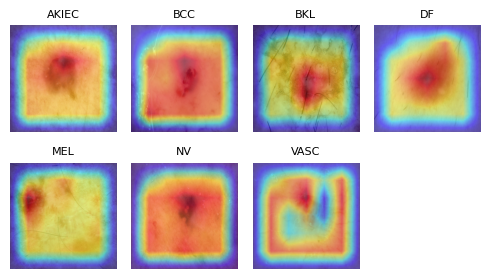

CPU times: user 19.7 s, sys: 434 ms, total: 20.1 s
Wall time: 30.5 s


In [ ]:
%%time
from matplotlib import cm
from tf_keras_vis.scorecam import Scorecam

# Create ScoreCAM object
scorecam = Scorecam(model, model_modifier=replace2linear)

# Generate heatmap with Faster-ScoreCAM
cam = scorecam(score,
               X,
               penultimate_layer=-1,
               max_N=10)

## Since v0.6.0, calling `normalize()` is NOT necessary.
# cam = normalize(cam)

# Calculate the number of rows and columns for subplots
num_rows = 2
num_cols = (num_images + 1) // num_rows

# Render
f, ax = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(5, 3))

for i, title in enumerate(image_titles):
    row = i // num_cols
    col = i % num_cols

    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[row, col].set_title(title, fontsize=8)
    ax[row, col].imshow(image_array[i])
    ax[row, col].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[row, col].axis('off')

# Remove any empty subplots
for i in range(len(image_titles), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    f.delaxes(ax[row, col])

plt.tight_layout()
plt.show()

4/4 [==============================] - 13s 610ms/step


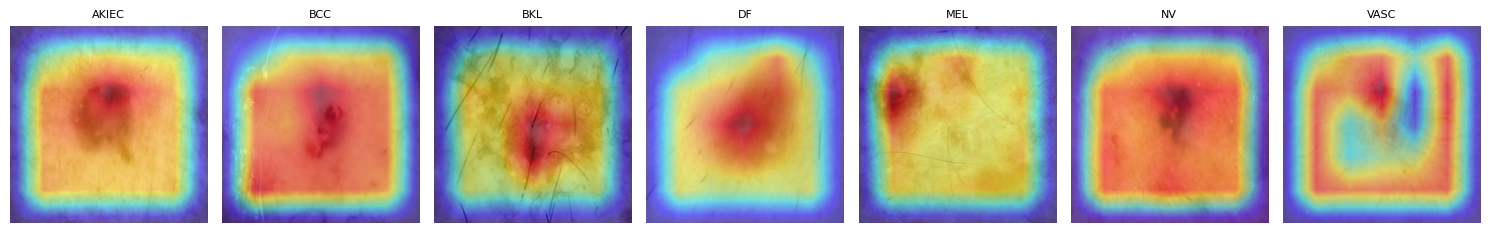

CPU times: user 20 s, sys: 924 ms, total: 20.9 s
Wall time: 31.5 s


In [ ]:
%%time
from matplotlib import pyplot as plt, cm
from tf_keras_vis.scorecam import Scorecam

# Assuming you have already defined model and replace2linear

# Create ScoreCAM object
scorecam = Scorecam(model, model_modifier=replace2linear)

# Generate heatmaps with Faster-ScoreCAM
cam = scorecam(score, X, penultimate_layer=-1, max_N=10)

# Calculate the number of images
num_images = len(image_titles)

# Create a single row plot
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)

    combined_image = cv2.addWeighted(image_array[i], 0.5, heatmap, 0.5, 0)

    axes[i].set_title(title, fontsize=8)
    axes[i].imshow(combined_image)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Faster Score-CAM for Random Image

4/4 [==============================] - 6s 193ms/step


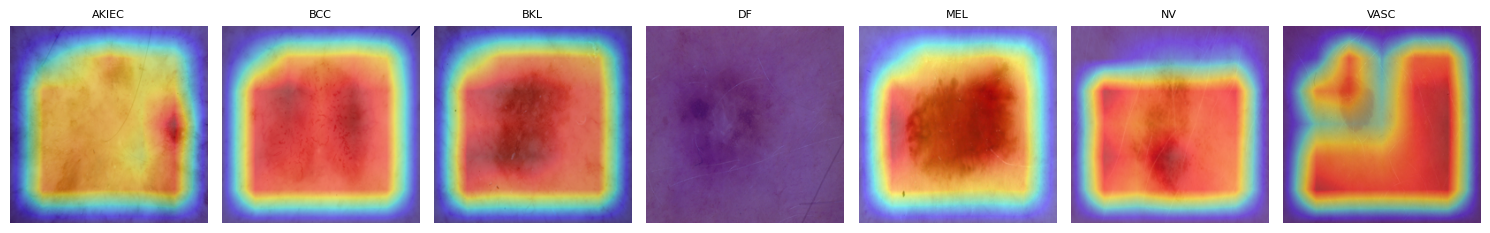

CPU times: user 14.7 s, sys: 591 ms, total: 15.3 s
Wall time: 15.8 s


In [ ]:
%%time
from matplotlib import pyplot as plt, cm
from tf_keras_vis.scorecam import Scorecam

# Assuming you have already defined model and replace2linear

# Create ScoreCAM object
scorecam = Scorecam(model, model_modifier=replace2linear)

# Generate heatmaps with Faster-ScoreCAM
cam = scorecam(score, X, penultimate_layer=-1, max_N=10)

# Calculate the number of images
num_images = len(image_titles)

# Create a single row plot
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)

    combined_image = cv2.addWeighted(image_array[i], 0.5, heatmap, 0.5, 0)

    axes[i].set_title(title, fontsize=8)
    axes[i].imshow(combined_image)
    axes[i].axis('off')

plt.tight_layout()
plt.show()